# Create: Feature Engineering Pipeline for Forecasting
Conda env: `time-series`  
11 Feb 2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering pipelines
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (LagFeatures, WindowFeatures)
from sklearn.pipeline import Pipeline

In [2]:
# Configs
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) EDA
The idea is to explore the classes and transformations from `feature_engine` to better understand it.

* **1)** Datetime features
    * **1.1)** Month
    * **1.2)** Week of Month
* **2)** Cyclical features
* **3)** Lag features
    * **3.1)** Sales of the previous week
* **4)** Window features
    * **4.1)** Mean: of the previous 2 & 4 weeks. 
    * **4.2)** Max: of the previous 2 & 4 weeks.
    * **4.3)** Minx: of the previous 2 & 4 weeks.

### 1.1) Input data

In [3]:
filename = "../datasets/online_retail_dataset.csv"

data = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
    ).rename(columns={"United Kingdom": "sales"})
data

,sales
week,
2009-12-06,"213,000.3500"
2009-12-13,"195,810.0400"
2009-12-20,"182,396.7400"
2009-12-27,"22,007.7700"
2010-01-03,0.0000
...,...
2011-11-13,"229,378.0100"
2011-11-20,"221,870.2900"
2011-11-27,"210,741.7600"


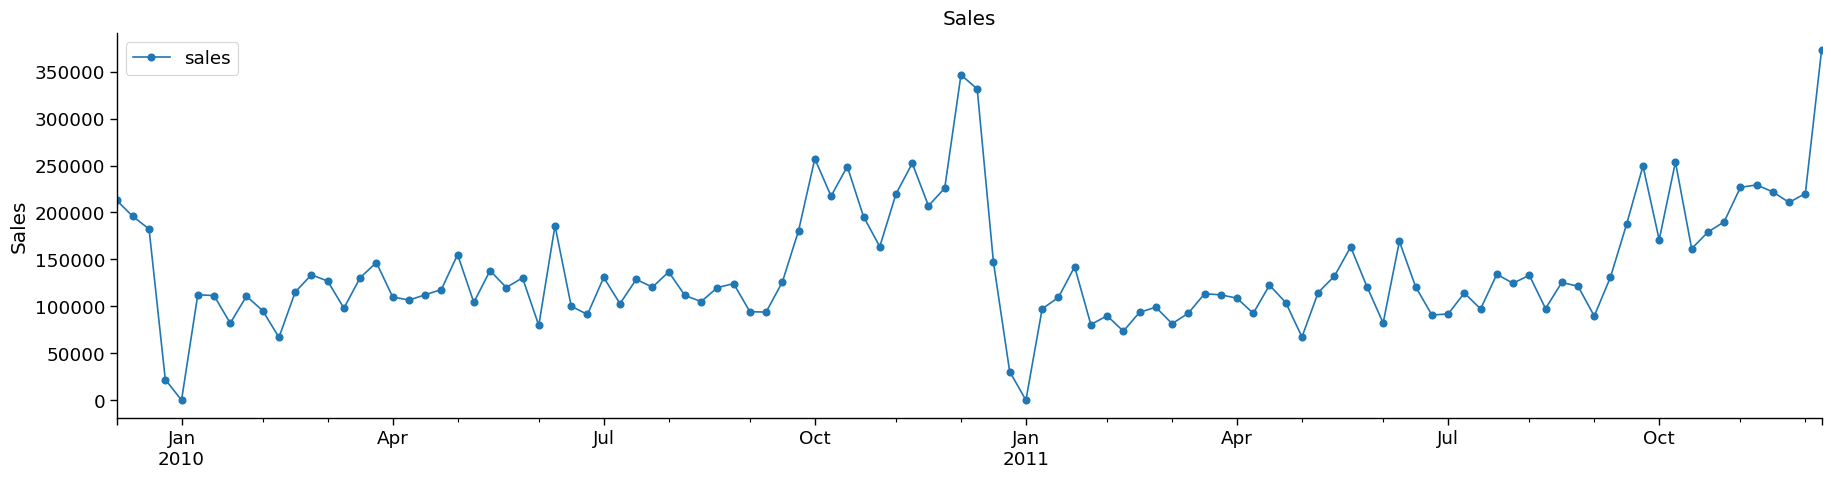

In [4]:
data.plot(marker="o")

plt.title("Sales")
plt.legend(loc="upper left")
plt.ylabel("Sales")
plt.xlabel("")
plt.show()

### 1.2) Explore Pipeline steps

In [5]:
# 1) Datetime features
dtf = DatetimeFeatures(
    variables="index",
    features_to_extract=[
        "month",
    ]
)

# 1, 2, 3, 4, 1, 2
data = dtf.fit_transform(data)
data

,sales,month
week,,
2009-12-06,"213,000.3500",12
2009-12-13,"195,810.0400",12
2009-12-20,"182,396.7400",12
2009-12-27,"22,007.7700",12
2010-01-03,0.0000,1
...,...,...
2011-11-13,"229,378.0100",11
2011-11-20,"221,870.2900",11
2011-11-27,"210,741.7600",11


In [6]:
# 2) Cyclical features
cyclical = CyclicalFeatures(
    variables=["month",],  
    drop_original=False, 
)

data = cyclical.fit_transform(data)
data.head()

,sales,month,month_sin,month_cos
week,,,,
2009-12-06,"213,000.3500",12,-0.0000,1.0000
2009-12-13,"195,810.0400",12,-0.0000,1.0000
2009-12-20,"182,396.7400",12,-0.0000,1.0000
2009-12-27,"22,007.7700",12,-0.0000,1.0000
2010-01-03,0.0000,1,0.5000,0.8660


In [7]:
# 3) Lag features
lagf = LagFeatures(
    variables= ["sales"],
    freq= ["1W"],
    missing_values="ignore"
)

data = lagf.fit_transform(data)
data

,sales,month,month_sin,month_cos,sales_lag_1W
week,,,,,
2009-12-06,"213,000.3500",12,-0.0000,1.0000,NaN
2009-12-13,"195,810.0400",12,-0.0000,1.0000,"213,000.3500"
2009-12-20,"182,396.7400",12,-0.0000,1.0000,"195,810.0400"
2009-12-27,"22,007.7700",12,-0.0000,1.0000,"182,396.7400"
2010-01-03,0.0000,1,0.5000,0.8660,"22,007.7700"
...,...,...,...,...,...
2011-11-13,"229,378.0100",11,-0.5000,0.8660,"226,770.5300"
2011-11-20,"221,870.2900",11,-0.5000,0.8660,"229,378.0100"
2011-11-27,"210,741.7600",11,-0.5000,0.8660,"221,870.2900"


In [8]:
# 4) Window features
winf = WindowFeatures(
    variables=["sales"],
    window=[2,4],
    functions=["mean", "max", "min"]
)

data = winf.fit_transform(data)
data

,sales,month,month_sin,month_cos,sales_lag_1W,sales_window_2_mean,sales_window_2_max,sales_window_2_min,sales_window_4_mean,sales_window_4_max,sales_window_4_min
week,,,,,,,,,,,
2009-12-06,"213,000.3500",12,-0.0000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-13,"195,810.0400",12,-0.0000,1.0000,"213,000.3500",NaN,NaN,NaN,NaN,NaN,NaN
2009-12-20,"182,396.7400",12,-0.0000,1.0000,"195,810.0400","204,405.1950","213,000.3500","195,810.0400",NaN,NaN,NaN
2009-12-27,"22,007.7700",12,-0.0000,1.0000,"182,396.7400","189,103.3900","195,810.0400","182,396.7400",NaN,NaN,NaN
2010-01-03,0.0000,1,0.5000,0.8660,"22,007.7700","102,202.2550","182,396.7400","22,007.7700","153,303.7250","213,000.3500","22,007.7700"
...,...,...,...,...,...,...,...,...,...,...,...
2011-11-13,"229,378.0100",11,-0.5000,0.8660,"226,770.5300","208,402.3650","226,770.5300","190,034.2000","189,337.3350","226,770.5300","161,438.5400"
2011-11-20,"221,870.2900",11,-0.5000,0.8660,"229,378.0100","228,074.2700","229,378.0100","226,770.5300","206,322.2025","229,378.0100","179,106.0700"
2011-11-27,"210,741.7600",11,-0.5000,0.8660,"221,870.2900","225,624.1500","229,378.0100","221,870.2900","217,013.2575","229,378.0100","190,034.2000"


In [9]:
data.isna().sum()

sales                  0
month                  0
month_sin              0
month_cos              0
sales_lag_1W           1
sales_window_2_mean    2
sales_window_2_max     2
sales_window_2_min     2
sales_window_4_mean    4
sales_window_4_max     4
sales_window_4_min     4
dtype: int64

In [10]:
print(data.shape)

(106, 11)


In [11]:
# 5) Drop missing data
imputer = DropMissingData()
data = imputer.fit_transform(data)
print(data.shape)
data

(102, 11)


,sales,month,month_sin,month_cos,sales_lag_1W,sales_window_2_mean,sales_window_2_max,sales_window_2_min,sales_window_4_mean,sales_window_4_max,sales_window_4_min
week,,,,,,,,,,,
2010-01-03,0.0000,1,0.5000,0.8660,"22,007.7700","102,202.2550","182,396.7400","22,007.7700","153,303.7250","213,000.3500","22,007.7700"
2010-01-10,"112,318.8500",1,0.5000,0.8660,0.0000,"11,003.8850","22,007.7700",0.0000,"100,053.6375","195,810.0400",0.0000
2010-01-17,"111,460.4700",1,0.5000,0.8660,"112,318.8500","56,159.4250","112,318.8500",0.0000,"79,180.8400","182,396.7400",0.0000
2010-01-24,"82,065.3310",1,0.5000,0.8660,"111,460.4700","111,889.6600","112,318.8500","111,460.4700","61,446.7725","112,318.8500",0.0000
2010-01-31,"110,790.5910",1,0.5000,0.8660,"82,065.3310","96,762.9005","111,460.4700","82,065.3310","76,461.1628","112,318.8500",0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2011-11-13,"229,378.0100",11,-0.5000,0.8660,"226,770.5300","208,402.3650","226,770.5300","190,034.2000","189,337.3350","226,770.5300","161,438.5400"
2011-11-20,"221,870.2900",11,-0.5000,0.8660,"229,378.0100","228,074.2700","229,378.0100","226,770.5300","206,322.2025","229,378.0100","179,106.0700"
2011-11-27,"210,741.7600",11,-0.5000,0.8660,"221,870.2900","225,624.1500","229,378.0100","221,870.2900","217,013.2575","229,378.0100","190,034.2000"


In [12]:
# 6) Drop original time-series
drop_ts = DropFeatures(features_to_drop=["sales"])
data = drop_ts.fit_transform(data)
data

,month,month_sin,month_cos,sales_lag_1W,sales_window_2_mean,sales_window_2_max,sales_window_2_min,sales_window_4_mean,sales_window_4_max,sales_window_4_min
week,,,,,,,,,,
2010-01-03,1,0.5000,0.8660,"22,007.7700","102,202.2550","182,396.7400","22,007.7700","153,303.7250","213,000.3500","22,007.7700"
2010-01-10,1,0.5000,0.8660,0.0000,"11,003.8850","22,007.7700",0.0000,"100,053.6375","195,810.0400",0.0000
2010-01-17,1,0.5000,0.8660,"112,318.8500","56,159.4250","112,318.8500",0.0000,"79,180.8400","182,396.7400",0.0000
2010-01-24,1,0.5000,0.8660,"111,460.4700","111,889.6600","112,318.8500","111,460.4700","61,446.7725","112,318.8500",0.0000
2010-01-31,1,0.5000,0.8660,"82,065.3310","96,762.9005","111,460.4700","82,065.3310","76,461.1628","112,318.8500",0.0000
...,...,...,...,...,...,...,...,...,...,...
2011-11-13,11,-0.5000,0.8660,"226,770.5300","208,402.3650","226,770.5300","190,034.2000","189,337.3350","226,770.5300","161,438.5400"
2011-11-20,11,-0.5000,0.8660,"229,378.0100","228,074.2700","229,378.0100","226,770.5300","206,322.2025","229,378.0100","179,106.0700"
2011-11-27,11,-0.5000,0.8660,"221,870.2900","225,624.1500","229,378.0100","221,870.2900","217,013.2575","229,378.0100","190,034.2000"


### 1.3) Apply Pipeline

In [13]:
filename = "../datasets/online_retail_dataset.csv"

data = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
    ).rename(columns={"United Kingdom": "sales"})
data

,sales
week,
2009-12-06,"213,000.3500"
2009-12-13,"195,810.0400"
2009-12-20,"182,396.7400"
2009-12-27,"22,007.7700"
2010-01-03,0.0000
...,...
2011-11-13,"229,378.0100"
2011-11-20,"221,870.2900"
2011-11-27,"210,741.7600"


In [14]:
# 1) Datetime features
dtf = DatetimeFeatures(
    variables="index",
    features_to_extract=[
        "month",
    ]
)
# 2) Cyclical features
cyclical = CyclicalFeatures(
    variables=["month",],  
    drop_original=False, 
)
# 3) Lag features
lagf = LagFeatures(
    variables= ["sales"],
    freq= ["1W"],
    missing_values="ignore"
)
# 4) Window features
winf = WindowFeatures(
    variables=["sales"],
    window=[2,4],
    functions=["mean", "max", "min"]
)
# 5) Drop missing data
imputer = DropMissingData()
# 6) Drop original time-series
drop_ts = DropFeatures(features_to_drop=["sales"])

# Pipeline
pipe = Pipeline([
    ("datetime_features", dtf), # 1)
    ("Periodic", cyclical), # 2)
    ("lagf", lagf), # 3)
    ("winf", winf), # 4) 
    ("dropna", imputer), # 5)
    ("drop_ts", drop_ts) # 6)
])

data = pipe.fit_transform(data)
data

,month,month_sin,month_cos,sales_lag_1W,sales_window_2_mean,sales_window_2_max,sales_window_2_min,sales_window_4_mean,sales_window_4_max,sales_window_4_min
week,,,,,,,,,,
2010-01-03,1,0.5000,0.8660,"22,007.7700","102,202.2550","182,396.7400","22,007.7700","153,303.7250","213,000.3500","22,007.7700"
2010-01-10,1,0.5000,0.8660,0.0000,"11,003.8850","22,007.7700",0.0000,"100,053.6375","195,810.0400",0.0000
2010-01-17,1,0.5000,0.8660,"112,318.8500","56,159.4250","112,318.8500",0.0000,"79,180.8400","182,396.7400",0.0000
2010-01-24,1,0.5000,0.8660,"111,460.4700","111,889.6600","112,318.8500","111,460.4700","61,446.7725","112,318.8500",0.0000
2010-01-31,1,0.5000,0.8660,"82,065.3310","96,762.9005","111,460.4700","82,065.3310","76,461.1628","112,318.8500",0.0000
...,...,...,...,...,...,...,...,...,...,...
2011-11-13,11,-0.5000,0.8660,"226,770.5300","208,402.3650","226,770.5300","190,034.2000","189,337.3350","226,770.5300","161,438.5400"
2011-11-20,11,-0.5000,0.8660,"229,378.0100","228,074.2700","229,378.0100","226,770.5300","206,322.2025","229,378.0100","179,106.0700"
2011-11-27,11,-0.5000,0.8660,"221,870.2900","225,624.1500","229,378.0100","221,870.2900","217,013.2575","229,378.0100","190,034.2000"
